In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from data_utils import put_in_PI, find_angle_id, find_next_frame, generate_sample
import json
from tqdm import tqdm

In [2]:
DATA_ROOT_DIR = "/home/user/Bureau/Dataset/udacity/"
DATA_DIR = "CH2_002_output/"

df = pd.read_csv(DATA_ROOT_DIR + DATA_DIR + 'interpolated.csv')

In [3]:
# extract image from center camera
center_cam_idx = df['frame_id'] == 'center_camera'
center_cam_df = df[center_cam_idx]

# Convert steering angle to [-pi, pi] and clamp too large angle
center_cam_df['angle'] = center_cam_df['angle'].apply(put_in_PI)

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
max_angle = max(center_cam_df['angle'])
min_angle = min(center_cam_df['angle'])
print("max_angle = ", max_angle, "\tmin_angle = ", min_angle)

max_angle =  1.90326191229 	min_angle =  -2.0507619381


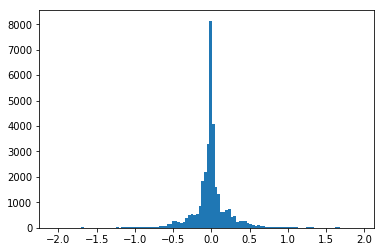

In [5]:
bin_width = 2 * np.pi / 180
num_bins = math.ceil((max_angle - min_angle) / bin_width) + 1
bins = [min_angle + i * bin_width for i in range(num_bins)]

bins_cnt, bins_edge, _ = plt.hist(center_cam_df['angle'], bins=bins)

# Calculate weight of each class of angle 
* Find median of the whole dataset
* Calculate weights for each class
The weight is calculated according to `median frequency balancing`

$w(c) = \frac{\text{meadian freq of whole dataset}}{\text{freq of class c}}$

*Ref: https://stats.stackexchange.com/questions/284265/understanding-median-frequency-balancing*

In [6]:
classes_freq = bins_cnt / len(center_cam_df)
# find median of the whole dataset
median_freq = np.median(classes_freq)
# claculate weight of each class
classes_weights = {}
for i, freq in enumerate(classes_freq):
    if freq < 1e-7:
        classes_weights[i] = 0
    else:
        classes_weights[i] =  median_freq / freq

In [7]:
# save classes_weights to file
# with open('s1p10_classes_weight.json', 'w') as outfile:
#     json.dump(classes_weights, outfile)

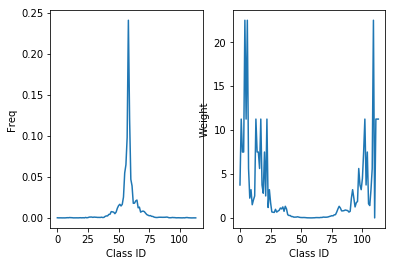

In [8]:
plt.subplot(121)
plt.plot(classes_freq)
plt.ylabel('Freq')
plt.xlabel('Class ID')
plt.subplot(122)
plt.plot([classes_weights[i] for i in range(len(classes_freq))])
plt.ylabel('Weight')
plt.xlabel('Class ID')
plt.show()

# Data prepration
Generate a training sample as a `dict` with the following keys:

* frame_name: only 1 string - filename of the current frame
* inter_frame_dist: list of 4 floats
* angle_id: (just for last 4 frames)
* angle_val (just for last 4 frames)


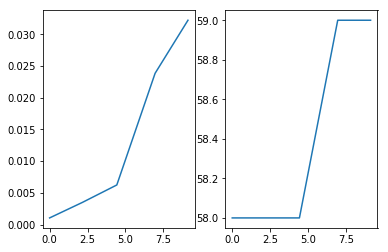

In [9]:
sample = generate_sample(0, center_cam_df, bins_edge, DATA_DIR)

plt.subplot(121)
plt.plot(sample['travelled_dist'], sample['angle_val'])
plt.subplot(122)
plt.plot(sample['travelled_dist'], sample['angle_id'])

In [10]:
sample

{'frame_name': 'CH2_002_output/center/1479424215880976321.jpg',
 'travelled_dist': [0.0,
  2.167672532084772,
  4.432201331099042,
  6.957963223668275,
  9.125691104787968],
 'angle_id': [58, 58, 58, 59, 59],
 'angle_val': [0.00103893906341,
  0.00349065847695,
  0.00623351662237,
  0.0238374389065,
  0.0322000511415]}

## Create dataset

In [12]:
dataset = []  # list of dictionary
now_idx_list = np.random.randint(0, high=len(center_cam_df)-1, size=int(0.6 * len(center_cam_df)))

for i in tqdm(now_idx_list):
    sample = generate_sample(i, center_cam_df, bins_edge, DATA_DIR)
    # check if sample is valid
    if sample:
        dataset.append(sample)

In [15]:
dataset_df = pd.DataFrame(dataset)
# dataset_df.to_csv("s1p10_" + DATA_DIR[:-1] + ".csv")

In [5]:
def datasetSeparate(dataframe, training_portion):
    """
    Separate dataframe into training set (training_portion%) and validation set (1 - training_portion)
    
    :param dataframe:
    
    :return:
        training_df, validation_df
    """
    # shuffle dataframe
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    # separate
    training_end = int(training_portion * len(dataframe))
    training_df = dataframe.iloc[: training_end, :]
    validation_df = dataframe.iloc[training_end: , :]
    
    return training_df, validation_df

In [3]:
dataset_df = pd.read_csv("s1p10_CH2_002_output.csv")

In [6]:
training_df, validation_df = datasetSeparate(dataset_df, 0.9)
training_df.to_csv("s1p10_" + DATA_DIR[:-1] + "_training.csv")
validation_df.to_csv("s1p10_" + DATA_DIR[:-1] + "_validation.csv")